In [8]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from scib_metrics.benchmark import Benchmarker

import matplotlib.pyplot as plt

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-05-03 10:14:57,511:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-05-03 10:14:57,627:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-05-03 10:14:57,724:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-05-03 10:14:57,812:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-05-03 10:14:57,899:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-05-03 10:14:58,119:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core

## preparing the model

In [ ]:
model = scPrint.load_from_checkpoint('../../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb = None)

#'../../data/main/gene_embeddings.parquet')
# new models
# p9eu2sti/epoc=7-step=40000.ckpt medium slightly older version. let's see
# c02qcgrx/epoch=24-step=125000.ckpt medium without learning gene embeddings
# vbd8bavn/epoch=17-step=90000.ckpt best medium with learning gene embeddings
# vbd8bavn/epoch=27-step=140000.ckpt medium with learning gene embeddings retraining for 10 epochs
# '../../data/temp/wli32e2j/last.ckpt' large without gene embeddings
# old models
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

## Loading the data

In [2]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7. 2PN6LTuSmJI2TSGl77TY.h5ad
# untrained on: BljRloq1xjcxRNDpejzI
# testdatasets=['/R4ZHoQegxXdSFNFY5LGe.h5ad', '/SHV11AEetZOms4Wh7Ehb.h5ad', '/V6DPJx8rP3wWRQ43LMHb.h5ad', '/Gz5G2ETTEuuRDgwm7brA.h5ad', '/YyBdEsN89p2aF4xJY1CW.h5ad', '/SO5yBTUDBgkAmz0QbG8K.h5ad', '/r4iCehg3Tw5IbCLiCIbl.h5ad', '/SqvXr3i3PGXM8toXzUf9.h5ad', '/REIyQZE6OMZm1S3W2Dxi.h5ad', '/rYZ7gs0E0cqPOLONC8ia.h5ad', '/FcwMDDbAQPNYIjcYNxoc.h5ad', '/fvU5BAMJrm7vrgDmZM0z.h5ad', '/gNNpgpo6gATjuxTE7CCp.h5ad'],

In [9]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint

In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [10]:
preprocessor = Preprocessor(subset_hvg=3000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [11]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

X was not raw counts, using 'counts' layer

Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 0 genes.
startin QC
Seeing 4678 outliers (28.56% of total dataset):
done


In [ ]:
adata

In [ ]:
sc.pl.embedding(adata, basis="X_UMAP", color=["cell_type", "development_stage", "assay", "disease", "sex", "self_reported_ethnicity"])

In [ ]:
Counter(adata.obs.assay)

In [ ]:
Counter(adata.obs.cell_type)

# good dataset

In [15]:
embed = Embedder(model, how="random expr", max_len=2200, add_zero_genes=0, num_workers=32, pred_embedding = ["cell_type_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## test dataset

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 16382 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

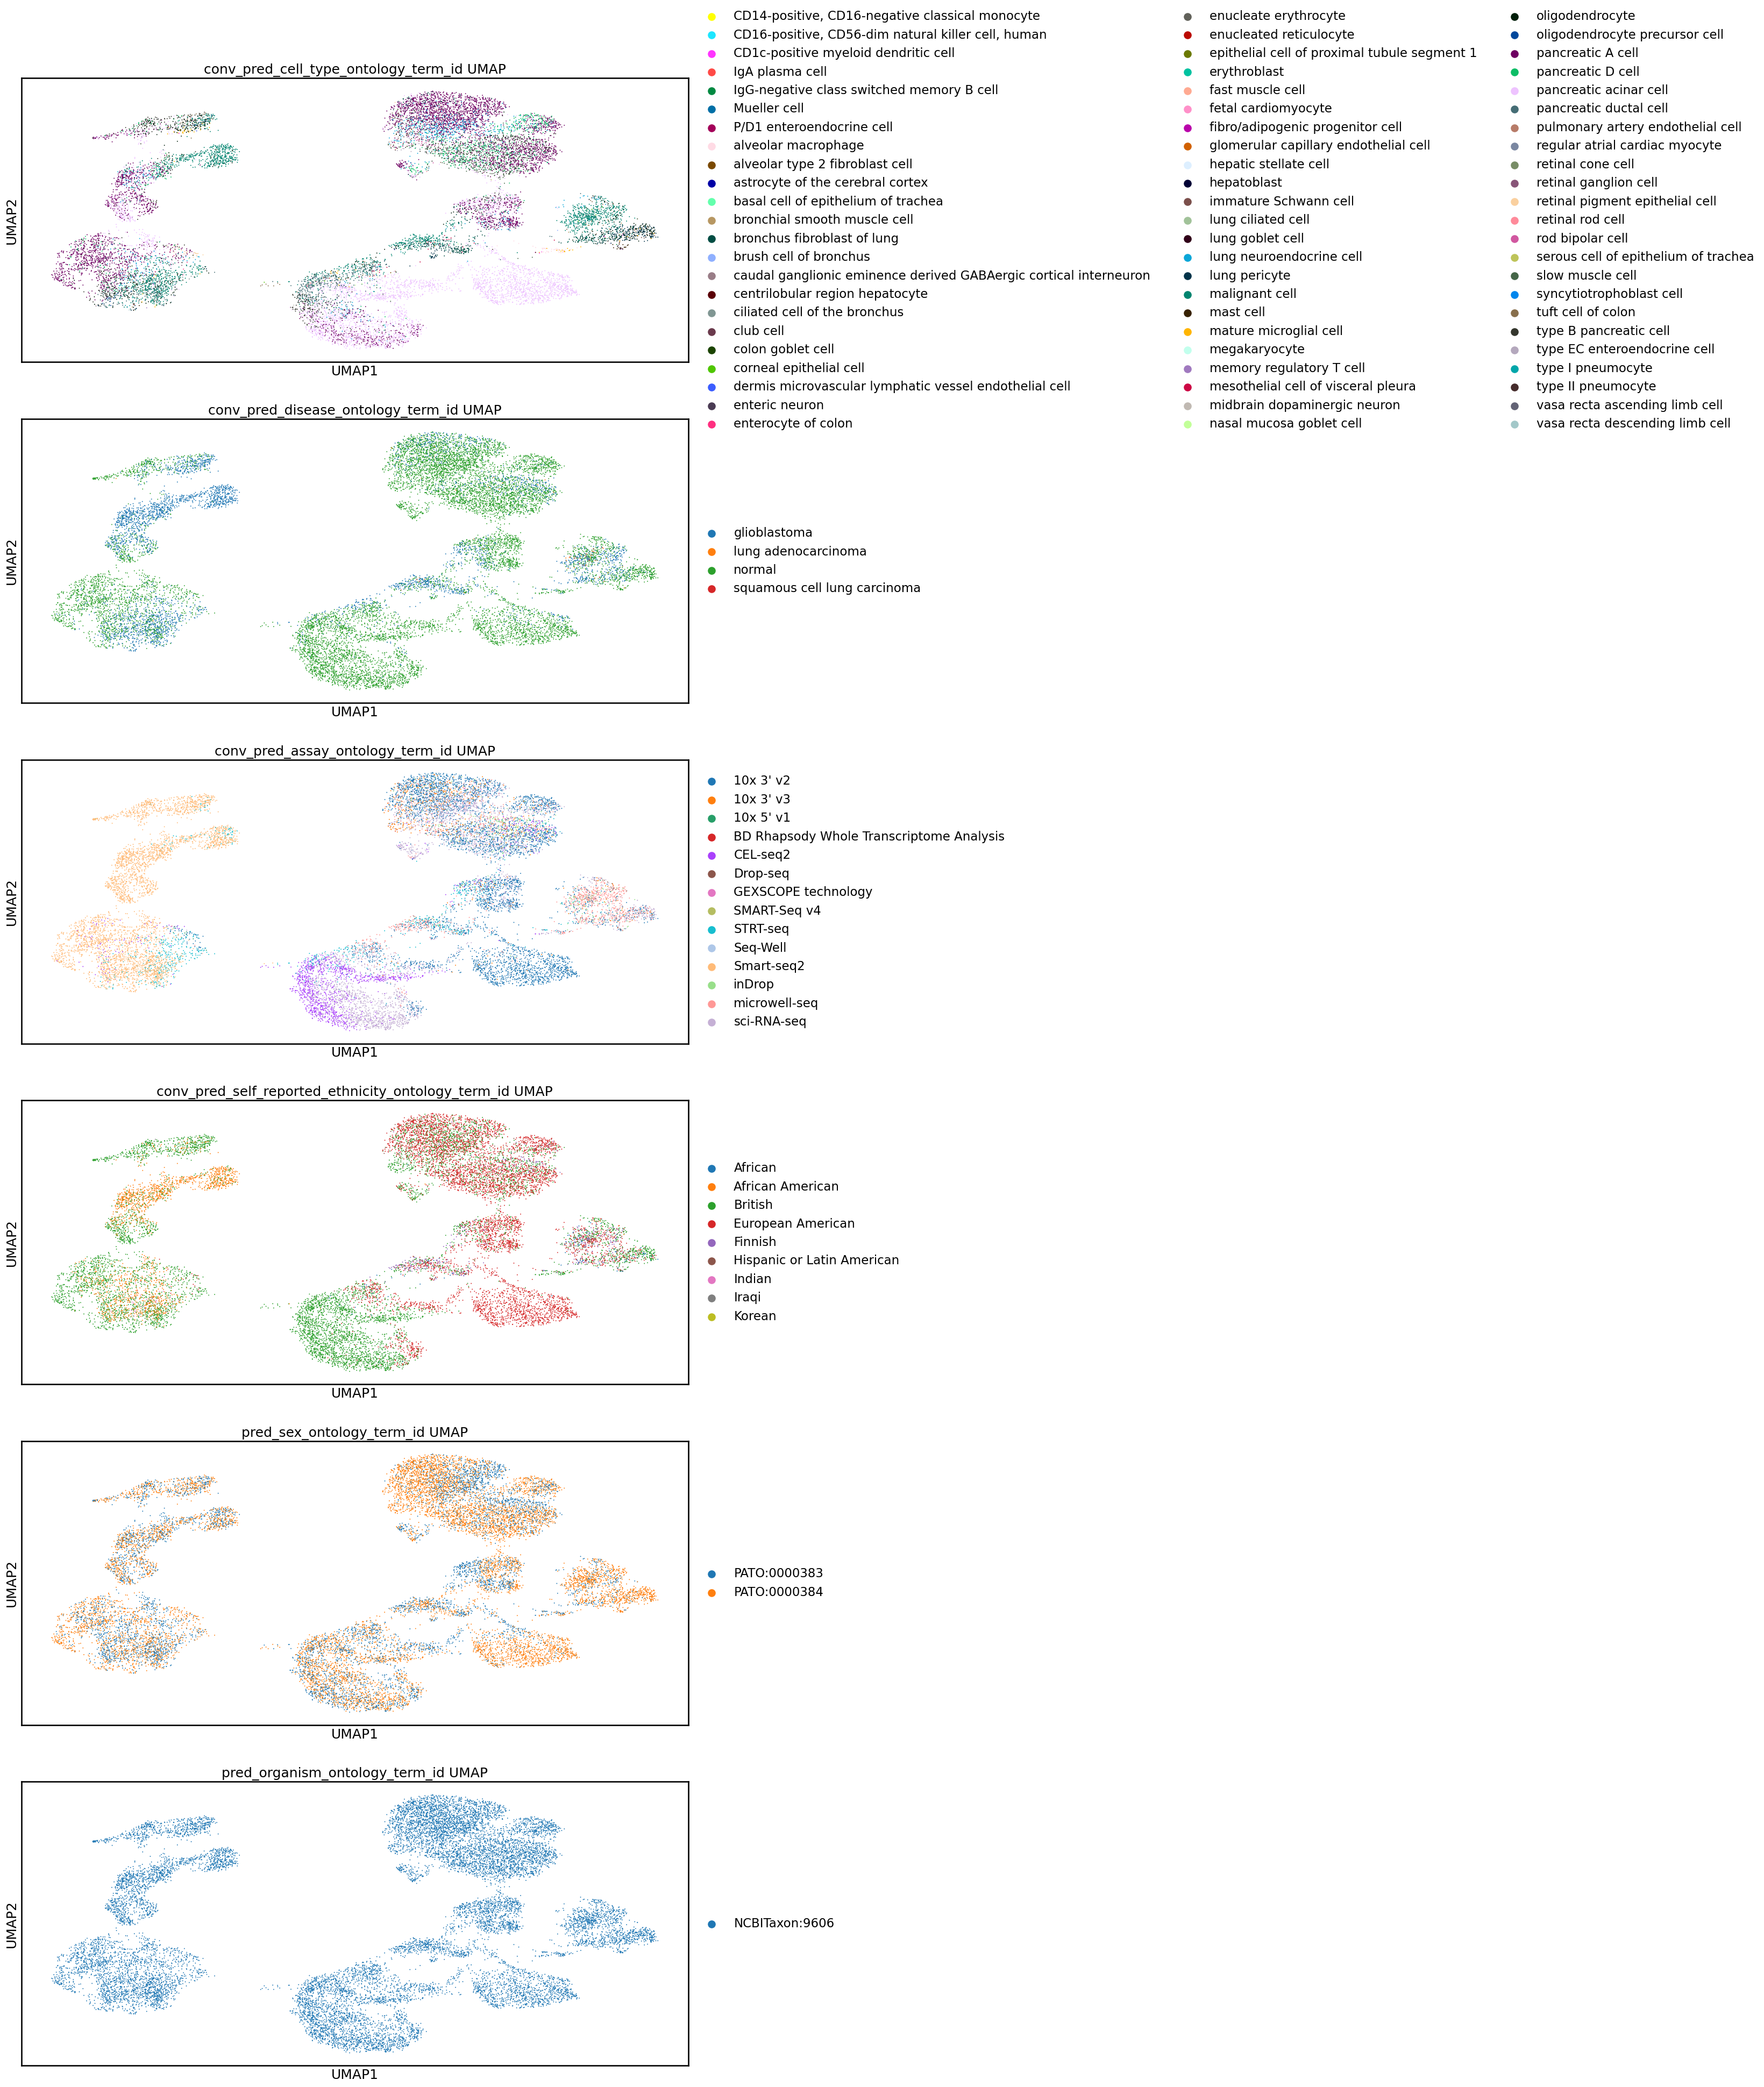

couldn't log to tensorboard
couldn't log to wandb
     organism_ontology_term_id
     accuracy: 1.0
 


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

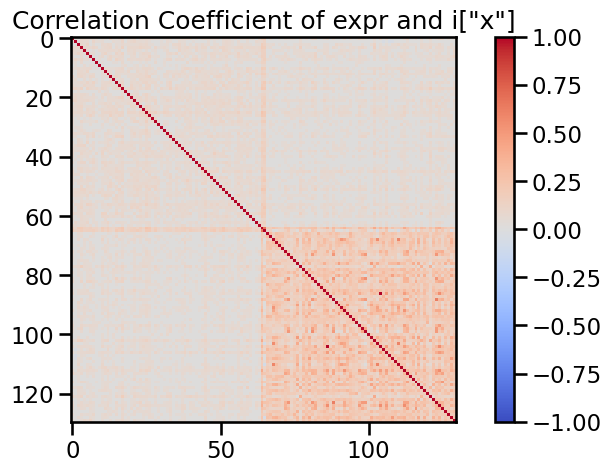

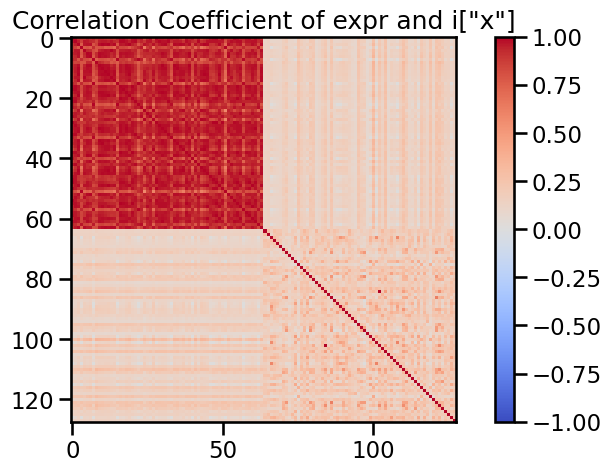

In [20]:
n_adata, metrics = embed(adata.copy()[:], cache=False, output_expression="none")

In [8]:
n_adata

AnnData object with n_obs × n_vars = 4000 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_

In [22]:
sc.pl.embedding(n_adata, basis="scprint_umap", color=["cell_type", "sex", "conv_pred_self_reported_ethnicity_ontology_term_id", "tissue", 'development_stage', 'nnz'])

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


KeyError: 'Could not find key cell_type in .var_names or .obs.columns.'

<Figure size 2911.2x960 with 0 Axes>

In [23]:
sc.pp.pca(n_adata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


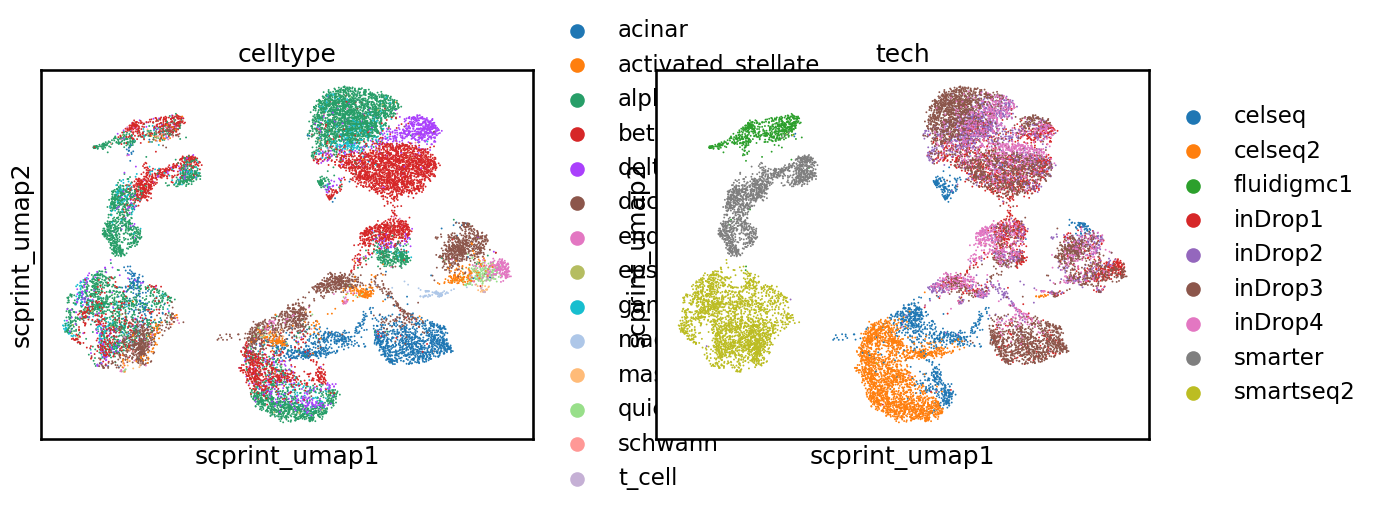

In [24]:
sc.pl.embedding(n_adata, basis="scprint_umap", color=["celltype", "tech"])

In [31]:
bm = Benchmarker(
    n_adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-05-03 10:25:37,650:INFO - isolated labels: no more than 4 batches per label
2024-05-03 10:25:37,881:INFO - Unable to initialize backend 'cuda': 
2024-05-03 10:25:37,883:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-05-03 10:25:37,933:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-05-03 10:25:37,935:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:52<00:25,  6.42s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [03:57<03:13, 64.59s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-05-03 10:29:35,856:INFO - isolated labels: no more than 4 batches per label

Metrics:  60%|██████    | 6/10 [02:33<01:02, 15.74s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.v

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [02:51<00:49, 16.54s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████ | 9/10 [02:52<00:08,  8.01s/it, Batch correction: pcr_comparison]██████████| 2/2 [06:50<00:00, 199.45s/it]██████████| 2/2 [06:50<00:00, 205.26s/it]

                                                                                         

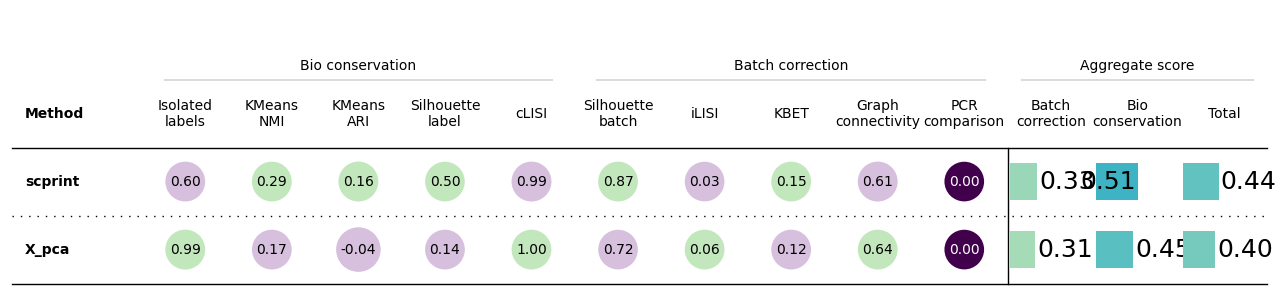

In [32]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
n_adata.obs.celltype.value_counts()

In [25]:
n_adata.obs.loc[n_adata.obs.celltype=="activated_stellate"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
bronchus fibroblast of lung              189
pancreatic acinar cell                    90
malignant cell                            63
oligodendrocyte                           31
lung pericyte                             29
                                        ... 
fetal cardiomyocyte                        0
glomerular capillary endothelial cell      0
hepatic stellate cell                      0
hepatoblast                                0
lung ciliated cell                         0
Name: count, Length: 69, dtype: int64

In [26]:
n_adata.obs.loc[n_adata.obs.celltype=="macrophage"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
alveolar macrophage                                51
mature microglial cell                             16
CD1c-positive myeloid dendritic cell                6
CD14-positive, CD16-negative classical monocyte     1
pancreatic acinar cell                              1
                                                   ..
glomerular capillary endothelial cell               0
hepatic stellate cell                               0
hepatoblast                                         0
immature Schwann cell                               0
vasa recta descending limb cell                     0
Name: count, Length: 69, dtype: int64

In [27]:
n_adata.obs.loc[n_adata.obs.celltype=="endothelial"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
lung pericyte                                         128
oligodendrocyte                                        73
bronchus fibroblast of lung                            19
mature microglial cell                                 16
pancreatic ductal cell                                 13
                                                     ... 
fibro/adipogenic progenitor cell                        0
hepatic stellate cell                                   0
hepatoblast                                             0
CD16-positive, CD56-dim natural killer cell, human      0
lung ciliated cell                                      0
Name: count, Length: 69, dtype: int64

In [28]:
n_adata.obs.loc[n_adata.obs.celltype=="gamma"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
pancreatic A cell                        330
pancreatic acinar cell                   114
lung neuroendocrine cell                  70
malignant cell                            43
pancreatic D cell                         34
                                        ... 
fibro/adipogenic progenitor cell           0
glomerular capillary endothelial cell      0
hepatic stellate cell                      0
hepatoblast                                0
vasa recta descending limb cell            0
Name: count, Length: 69, dtype: int64

In [29]:
n_adata.obs.loc[n_adata.obs.celltype=="beta"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
pancreatic A cell                                     1161
pancreatic acinar cell                                 750
type B pancreatic cell                                 542
slow muscle cell                                       454
pancreatic D cell                                      424
                                                      ... 
hepatic stellate cell                                    0
CD16-positive, CD56-dim natural killer cell, human       0
lung goblet cell                                         0
lung pericyte                                            0
vasa recta descending limb cell                          0
Name: count, Length: 69, dtype: int64

In [30]:
n_adata.obs.loc[n_adata.obs.celltype=="alpha"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
pancreatic A cell                                     3031
pancreatic acinar cell                                 919
lung neuroendocrine cell                               469
malignant cell                                         378
oligodendrocyte                                        130
                                                      ... 
glomerular capillary endothelial cell                    0
hepatoblast                                              0
CD16-positive, CD56-dim natural killer cell, human       0
lung goblet cell                                         0
vasa recta descending limb cell                          0
Name: count, Length: 69, dtype: int64

In [ ]:
n_adata

In [ ]:
{i:j for i,j in n_adata.obs.conv_pred_cell_type_ontology_term_id.value_counts().items() if j>10}

In [ ]:
n_adata.obs.loc[n_adata.obs.conv_pred_cell_type_ontology_term_id=="lung ciliated cell"].cell_type.value_counts()

In [ ]:
n_adata.obs.loc[n_adata.obs.conv_pred_cell_type_ontology_term_id=="mast cell"].cell_type.value_counts()

In [ ]:
n_adata.obs.loc[n_adata.obs.conv_pred_cell_type_ontology_term_id=="alveolar macrophage"].cell_type.value_counts()
# pneumocyte: CL:1000271
# type 2 CL:0002063

In [ ]:
n_adata = embed(adata.copy())

In [ ]:
n_adata.obs['tech'].value_counts()

In [ ]:
import bionty as bt

In [ ]:
obj = bt.CellType.public(organism="all")
{i: obj.search(i, field="name").ontology_id.iloc[0] for i in set(n_adata.obs['celltype'])}

In [ ]:
fine = {"gamma": "CL:0000453",
"beta": "CL:0000169", # "CL:0008024"
"epsilon": "CL:0005019", # "CL:0008024"
"acinar": "CL:0000622",
'delta': 'CL:0000173', #"CL:0008024"
'schwann': 'CL:0002573', # "CL:0000125"
'activated_stellate': 'CL:0000057',
'alpha': 'CL:0000171',# "CL:0008024"
'mast': 'CL:0000097',
'quiescent_stellate': 'CL:0000057',
't_cell': 'CL:0000084',
'endothelial': 'CL:0000115',
'ductal': 'CL:0002079', #CL:0000068
'macrophage': 'CL:0000235',
}
coarse = {
"gamma": "CL:0000453",
"beta": "CL:0008024",
"epsilon": "CL:0008024",
"acinar": "CL:0000622",
'delta': "CL:0008024",
'schwann': "CL:0000125",
'activated_stellate': 'CL:0000057',
'alpha': "CL:0008024",
'mast': 'CL:0000097',
'quiescent_stellate': 'CL:0000057',
't_cell': 'CL:0000084',
'endothelial': 'CL:0000115',
'ductal': "CL:0000068",
'macrophage': 'CL:0000235',
}

In [ ]:
translate({k:n for k,n in n_adata.obs['pred_cell_type_ontology_term_id'].value_counts().items() if n>20})

In [ ]:
n_adata.obs[n_adata.obs['pred_cell_type_ontology_term_id'] == "CL:0000169"].celltype.value_counts()

In [ ]:
n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(coarse)

In [ ]:
for label in embed.model.labels:
    res = []
    if label not in n_adata.obs.columns:
        continue
    class_topred = embed.model.label_decoders[label].values()
    if label in embed.model.cls_hierarchy:
        class_groupings = {
            k: [
                i.ontology_id
                for i in bt.CellType.filter(ontology_id=k).first().children.all()
            ]
            for k in set(n_adata.obs[label].unique()) - set(class_topred)
        }
    for pred, true in n_adata.obs[["pred_" + label, label]].values:
        if pred == true:
            res.append(True)
            continue

        if label in embed.model.cls_hierarchy:
            if true in class_groupings:
                res.append(pred in class_groupings[true])
                continue
            elif true not in class_topred:
                raise ValueError(f"true label {true} not in available classes")
        elif true not in class_topred:
            raise ValueError(f"true label {true} not in available classes")
        res.append(False)
    print("    ", label)
    print("     accuracy:", sum(res) / len(res))
    print(" ")

In [ ]:
translate(n_adata.obs['celltype'].unique().tolist())

In [ ]:
n_adata

In [ ]:
sc.pp.pca(n_adata)

In [ ]:
bm = Benchmarker(
    n_adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=6,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
bm.plot_results_table(min_max_scale=False)

## results from running it on most famous methods

In [ ]:
# lung

In [ ]:
n_adata = embed(adata.copy())

In [ ]:
sc.pl.embedding(n_adata,basis="scprint_umap" ,color=["protocol", "cell_type", "batch"])

In [ ]:
n_adata

In [ ]:
sc.pp.pca(n_adata)

In [ ]:
sc.pl.embedding(n_adata, color=['cell_type', 'batch'], basis="scprint_umap")

In [ ]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=8,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

![](https://scib-metrics.readthedocs.io/en/stable/_images/72fe472fdb279e95aba93bd88bf06ad186ff74cc30d6ec63c47b0025da83ccc0.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN